# Visualize drought impacts in hive plots

## This is performed for SOWs that meet variability, mean and drought occurrence conditions

### Used to make Figs. 7, 8, and 11


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.gridspec as grid_spec

Classify realizations into their characteristics (variability, persistence, basin deliveries)

In [22]:
# Load in sample information to classify realizations on variability and persistence
parameter_values = pd.read_csv('../streamflow_data/LHsamples_wider_100_AnnQonly.txt', sep='\t', lineterminator='\r', header=0)
variability_cat_samples = parameter_values[(parameter_values['sigma_dry'] <= 1.38) & 
                                           (parameter_values['sigma_dry'] >= 0.76)].index.values
mean_cat_samples = parameter_values[(parameter_values['mu_dry'] <= 1.01) & 
                                           (parameter_values['mu_dry'] >= 0.99)].index.values
variability_cat_realizations = np.concatenate([np.arange(x*10+1, x*10+10+1) for x in variability_cat_samples], 
                                              axis=0 )
mean_cat_realizations = np.concatenate([np.arange(x*10+1, x*10+10+1) for x in mean_cat_samples], axis=0 )

In [23]:
# Load in all drought counts for all realizations
droughts_df = pd.read_csv('../data/drought_counts_all_realizations.csv', index_col=0)
droughts_df.index = np.arange(1, len(droughts_df) + 1)

# Load in all drought impacts for all realizations using 100 years to set threshold
# Classification column uses drought occurences (drought_impacts_all_users_summary.ipynb)
drought_impacts_df = pd.read_csv('../data/drought_impacts_all_realizations.csv', index_col=0)
drought_impacts_df.index = np.arange(1, len(drought_impacts_df) + 1)

#Identify realizations that have basin deliveries similar or better than history
#I.e., realizations with 10th percentile equal or higher than 
#outflow_realizations = drought_impacts_df[drought_impacts_df['Outflow_10th'] >= 46819.99367].index.values

drought_impacts_df['Total counts']=droughts_df['Total counts']
#Identify realizations with as many droughts as history
drought_realizations = drought_impacts_df[drought_impacts_df['Total counts'] <= 30].index.values

In [24]:
len(drought_realizations)

340

In [25]:
drought_impacts_df

,Duration,Magnitude,%_users,Outflow_drought_min,Outflow_10th,%_users_36,Magnitude_36,%_users_37,Magnitude_37,%_users_38,...,%_users_52,Magnitude_52,%_users_53,Magnitude_53,%_users_70,Magnitude_70,%_users_72,Magnitude_72,Classification,Total counts
1,0,0.0,0.0,0.000000,50125.173581,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,History,0
2,0,3.0,33.0,36348.068995,42703.832639,11.0,0.0,8.0,1.0,18.0,...,0.0,0.0,39.0,7.0,60.0,6.0,74.0,7.0,History,21
3,0,4.0,32.0,37143.029513,40608.565705,7.0,0.0,8.0,1.0,14.0,...,0.0,0.0,44.0,7.0,40.0,5.0,70.0,9.0,Encompassing,50
4,0,4.0,30.0,36081.274282,45619.062274,14.0,0.0,8.0,1.0,13.0,...,0.0,0.0,39.0,7.0,40.0,6.0,66.0,10.0,History,15
5,0,3.0,30.0,45497.990115,45710.058200,4.0,0.0,8.0,0.0,13.0,...,0.0,0.0,44.0,7.0,40.0,4.0,66.0,9.0,History,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,0.0,0.0,0.000000,60848.662728,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,History,0
997,0,0.0,0.0,0.000000,59828.960840,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,History,0
998,0,4.0,28.0,40548.863952,55867.095007,7.0,0.0,8.0,1.0,16.0,...,0.0,0.0,39.0,7.0,40.0,6.0,66.0,8.0,History,13
999,0,0.0,0.0,0.000000,59923.353034,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,History,0


Classify outcomes into groups

In [26]:
no_users_thresh = 50
magnitude_thresh = 10
outflow_threshold = 44896.47152 

# create a list of our conditions
group_conditions = [
    # Criteria for group 1
    (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
    # Criteria for group 2
    (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh), 
    # Criteria for group 3
    (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
    # Criteria for group 4
    (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh), 
    # Criteria for group 5
    (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
    # Criteria for group 6
    (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh), 
    # Criteria for group 7
    (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
    # Criteria for group 8
    (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh)
    ] 

# create a list of the values we want to assign for each condition
group_values = list(np.arange(1,9))

# create a new column and use np.select to assign values to it using our lists as arguments
drought_impacts_df['Group'] = np.select(group_conditions, group_values)

In [27]:
drought_impacts_df['Group'].value_counts()

2    331
8    294
4    218
1    114
6     39
5      4
Name: Group, dtype: int64

In [28]:
#Repeat classification, but into three category pairs

classifications = ['Variance&Mean', 'Mean&Droughts', 'Droughts&Variance']

# create a list of our conditions
category_conditions = [
    # Criteria for category 1
    (drought_impacts_df.index.isin(variability_cat_realizations)) &
    (drought_impacts_df.index.isin(mean_cat_realizations)) , 
    # Criteria for category 2
    (drought_impacts_df.index.isin(mean_cat_realizations)) &
    (drought_impacts_df.index.isin(drought_realizations)), 
    # Criteria for category 3
    (drought_impacts_df.index.isin(drought_realizations)) &
    (drought_impacts_df.index.isin(variability_cat_realizations)) 
    ] 

# create a new column and use np.select to assign values to it using our lists as arguments
drought_impacts_df['Category'] = np.select(category_conditions, classifications)

In [29]:
drought_impacts_df['Category'].value_counts()

0                    777
Variance&Mean        100
Droughts&Variance     82
Mean&Droughts         41
Name: Category, dtype: int64

In [30]:
group_ratios = np.zeros((3,8))
max_in_group = 0
# Loop through all classifications and all groups and calculate ratios
for i, c in enumerate(classifications):
    total_reals = len(drought_impacts_df[drought_impacts_df['Category']==c])
    if total_reals>=max_in_group:
        max_in_group=total_reals
    for j, value in enumerate(group_values):
        group_ratios[i,j] = np.around(len(drought_impacts_df[(drought_impacts_df['Category']==c) & 
                                                        (drought_impacts_df['Group']==value)]),#/total_reals*100, 
                                 decimals=1)

In [31]:
# Create hive plot dataframe
# Calculate ratios of each group in each realization classification
df = pd.DataFrame(group_ratios, columns = [f'Group {x}' for x in group_values])

cum_sum_df = df.cumsum(axis=1)
cum_sum_df.insert(0, 'Initial_values', np.zeros(3))
cum_sum_df['angle_start'] = [0, 120, 240]
cum_sum_df['angle_end'] = [120, 240, 360]

Look at the impact group distribution across each dynamic set

In [32]:
cum_sum_df

,Initial_values,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,angle_start,angle_end
0,0.0,0.0,0.0,0.0,43.0,43.0,43.0,43.0,100.0,0,120
1,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,41.0,120,240
2,0.0,0.0,1.0,1.0,2.0,2.0,4.0,4.0,82.0,240,360


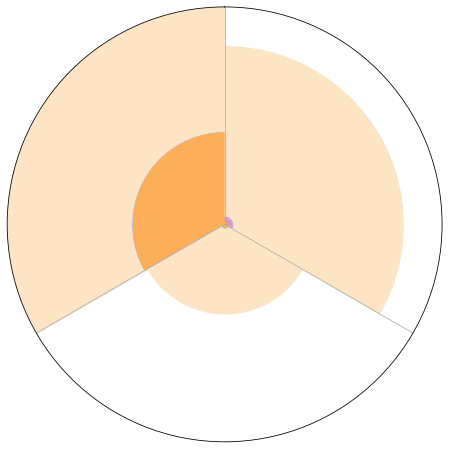

In [33]:
colors = ['#3E0081', '#A447A5', '#6586CD', '#FCAF58',
         '#857BBE', '#D39CD3', '#C1CEEB', '#FCE4C5']

plt.figure(figsize=(12,8))
ax = plt.subplot(polar=True)

# Extrapolate curves between angles
angles = [y/180*np.pi for x in [np.arange(x, x+125,5) for x in cum_sum_df.angle_start] for y in x]
segment_length = len(np.arange(0, 0+125,5))

# for every group extrapolate values and draw
for k in range(1, cum_sum_df.shape[1]-2):
    previous_values = sum([[cum_sum_df.iloc[i, k-1]]*segment_length for i in range(3)], [])
#     previous_values.append(previous_values[-1])
    values = sum([[cum_sum_df.iloc[i, k]]*segment_length for i in range(3)], [])
#     values.append(values[-1])
    
    # Plot data
    ax.fill_between(angles, previous_values, values, color=colors[k-1], label=f'Group {k}')

ax.set_thetagrids([0, 120, 240], ['','',''])#['Variability', 'Persistence', 'Drought\noccurrence'], fontsize=16)
ax.xaxis.set_tick_params(pad=30)
ax.set_ylim([0,max_in_group])
ax.set_yticklabels([])
ax.set_rticks([])

#ax.legend(loc='upper left')


ax.set_theta_zero_location("N")


plt.savefig('stationary_hive.svg')

# Zoom in specific water districts

In [14]:
# Function that does all classification calculations for each water district

no_users_thresh = 50
magnitude_thresh = 10
drought_years = 20

drought_impacts_df=drought_impacts_df.fillna(0)

def group_classifications_wds(drought_impacts_df, wd):
    # create a list of our conditions
    group_conditions = [
        # Criteria for group 1
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] >= no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] >= magnitude_thresh), 
        # Criteria for group 2
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] >= no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] < magnitude_thresh), 
        # Criteria for group 3
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] < no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] >= magnitude_thresh),     
        # Criteria for group 4
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] < no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] < magnitude_thresh), 
        # Criteria for group 5
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] >= no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] >= magnitude_thresh), 
        # Criteria for group 6
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] >= no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] < magnitude_thresh), 
        # Criteria for group 7
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] < no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] >= magnitude_thresh),     
        # Criteria for group 8
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df[f"%_users_{wd}"] < no_users_thresh) & 
        (drought_impacts_df[f"Magnitude_{wd}"] < magnitude_thresh)
        ] 

    # create a list of the values we want to assign for each condition
    group_values = list(np.arange(1,9))

    # create a new column and use np.select to assign values to it using our lists as arguments
    drought_impacts_df['Group'] = np.select(group_conditions, group_values)
    
    group_ratios = np.zeros((3,8))
    max_in_group = 0
    # Loop through all classifications and all groups and calculate ratios
    for i, c in enumerate(classifications):
        total_reals = len(drought_impacts_df[drought_impacts_df['Category']==c])
        if total_reals>=max_in_group:
            max_in_group=total_reals
        for j, value in enumerate(group_values):
            group_ratios[i,j] = np.around(len(drought_impacts_df[(drought_impacts_df['Category']==c) & 
                                                            (drought_impacts_df['Group']==value)]),#/total_reals*100, 
                                     decimals=1)
    # Create hive plot dataframe
    # Calculate ratios of each group in each realization classification
    df = pd.DataFrame(group_ratios, columns = [f'Group {x}' for x in group_values])

    cum_sum_df = df.cumsum(axis=1)
    cum_sum_df.insert(0, 'Initial_values', np.zeros(3))
    cum_sum_df['angle_start'] = [0, 120, 240]
    cum_sum_df['angle_end'] = [120, 240, 360]
    return cum_sum_df, max_in_group


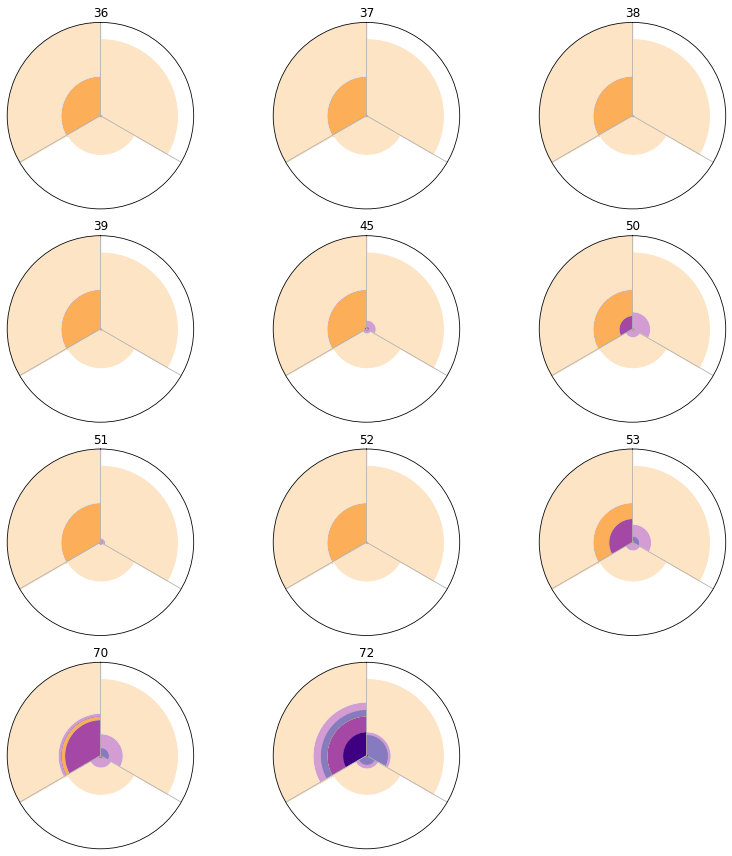

In [15]:
WDs = [36, 37, 38, 39, 45, 50, 51, 52, 53, 70, 72]

fig, axs = plt.subplots(4, 3, figsize=(12, 12))

for i, wd in enumerate(WDs): 
    
    ax = plt.subplot(4, 3, i+1, polar=True)
    
    #Get impacts for specific group
    cum_sum_df, max_in_group = group_classifications_wds(drought_impacts_df, wd)

    # Extrapolate curves between angles
    angles = [y/180*np.pi for x in [np.arange(x, x+125,5) for x in cum_sum_df.angle_start] for y in x]
    segment_length = len(np.arange(0, 0+125,5))

    # for every group extrapolate values and draw
    for k in range(1, cum_sum_df.shape[1]-2):
        previous_values = sum([[cum_sum_df.iloc[i, k-1]]*segment_length for i in range(3)], [])
    #     previous_values.append(previous_values[-1])
        values = sum([[cum_sum_df.iloc[i, k]]*segment_length for i in range(3)], [])
    #     values.append(values[-1])

        # Plot data
        ax.fill_between(angles, previous_values, values, color=colors[k-1], label=f'Group {k}')

        ax.xaxis.set_tick_params(pad=30)

        ax.set_ylim([0,max_in_group])
        ax.set_yticklabels([])
        ax.set_rticks([])
        ax.set_thetagrids([0, 120, 240], [])
        ax.set_theta_zero_location("N")
        ax.set_title(f'{wd}')
        
ax = plt.subplot(4, 3, 12, polar=True)    
ax.set_axis_off()
plt.tight_layout(h_pad=None, w_pad=None)
plt.savefig('wd_impacts_stationary.svg')
plt.show()

# Wrap everything in functions to explore all combinations of thresholds

In [16]:
# Function that does all classification calculations
def group_classifications(drought_impacts_df, outflow_threshold, no_users_thresh, magnitude_thresh):
    # create a list of our conditions
    group_conditions = [
        # Criteria for group 1
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
        # Criteria for group 2
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh), 
        # Criteria for group 3
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
        # Criteria for group 4
        (drought_impacts_df['Outflow_10th'] <= outflow_threshold) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh), 
        # Criteria for group 5
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
        # Criteria for group 6
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh), 
        # Criteria for group 7
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
        # Criteria for group 8
        (drought_impacts_df['Outflow_10th'] > outflow_threshold) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh)
        ]  

    # create a list of the values we want to assign for each condition
    group_values = list(np.arange(1,9))

    # create a new column and use np.select to assign values to it using our lists as arguments
    drought_impacts_df['Group'] = np.select(group_conditions, group_values)
    
    group_ratios = np.zeros((3,8))
    max_in_group = 0
    # Loop through all classifications and all groups and calculate ratios
    for i, c in enumerate(classifications):
        total_reals = len(drought_impacts_df[drought_impacts_df['Category']==c])
        if total_reals>=max_in_group:
            max_in_group=total_reals
        for j, value in enumerate(group_values):
            group_ratios[i,j] = np.around(len(drought_impacts_df[(drought_impacts_df['Category']==c) & 
                                                            (drought_impacts_df['Group']==value)]),#/total_reals*100, 
                                     decimals=1)
    # Create hive plot dataframe
    # Calculate ratios of each group in each realization classification
    df = pd.DataFrame(group_ratios, columns = [f'Group {x}' for x in group_values])

    cum_sum_df = df.cumsum(axis=1)
    cum_sum_df.insert(0, 'Initial_values', np.zeros(3))
    cum_sum_df['angle_start'] = [0, 120, 240]
    cum_sum_df['angle_end'] = [120, 240, 360]
    return cum_sum_df, max_in_group

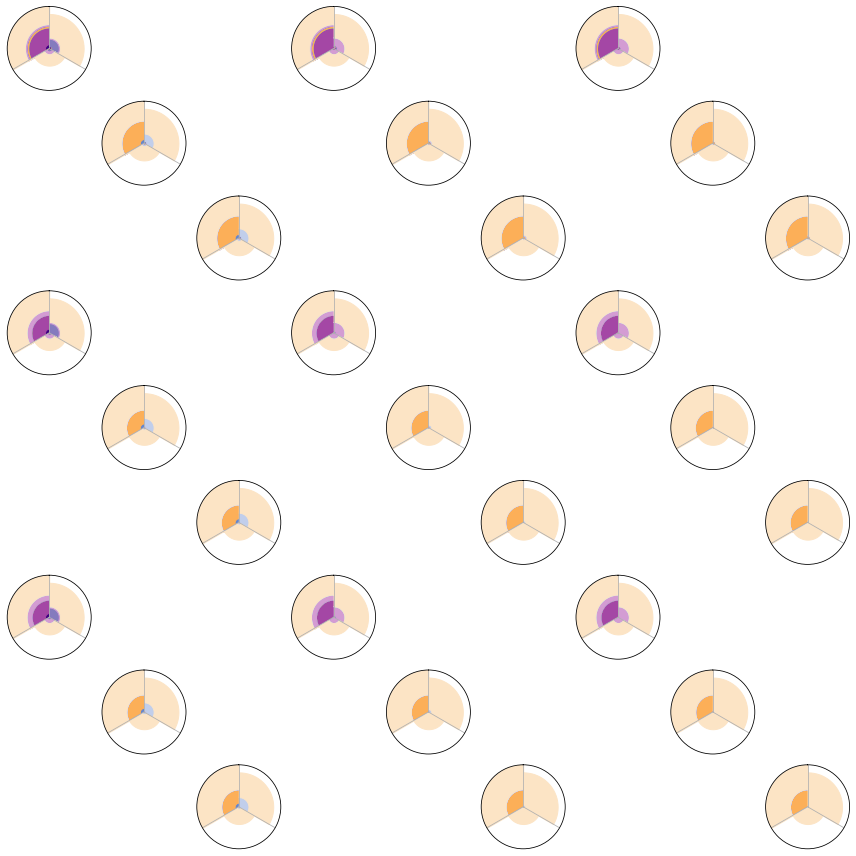

In [17]:
no_users_thresholds = [25, 50, 75]
magnitude_thresholds = [5, 7, 10]
outflow_thresholds = [46819.99367, 44896.47152, 43776.47083] #as often, 2x as often, 10x as often
gs = (grid_spec.GridSpec(9,9))

# Create array of axis positions
pos_x = [[0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8]]
pos_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]
positions = []
for z in range(len(pos_y)):
    for w in range(len(pos_x[0])):
        positions.append([pos_y[z], pos_x[z][w]])

fig = plt.figure(figsize=(12,12))

#creating empty list
ax_objs = []
count=0
for i in range(len(outflow_thresholds)):
    for j in range(len(no_users_thresholds)):
        for h in range(len(magnitude_thresholds)):
            ax_objs.append(fig.add_subplot(gs[positions[count][0], positions[count][1]], polar=True))
            
            cum_sum_df, max_in_group = group_classifications(drought_impacts_df, outflow_thresholds[i], 
                                               no_users_thresholds[j], magnitude_thresholds[h])

            # Extrapolate curves between angles
            angles = [y/180*np.pi for x in [np.arange(x, x+125,5) for x in cum_sum_df.angle_start] for y in x]
            segment_length = len(np.arange(0, 0+125,5))

            # for every group extrapolate values and draw
            for k in range(1, cum_sum_df.shape[1]-2):
                previous_values = sum([[cum_sum_df.iloc[i, k-1]]*segment_length for i in range(3)], [])
                values = sum([[cum_sum_df.iloc[i, k]]*segment_length for i in range(3)], [])

                # Plot data
                ax_objs[-1].fill_between(angles, previous_values, values, color=colors[k-1], label=f'Group {k}')

            ax_objs[-1].xaxis.set_tick_params(pad=30)

            ax_objs[-1].set_ylim([0,max_in_group])
            ax_objs[-1].set_yticklabels([])
            ax_objs[-1].set_rticks([])
            ax_objs[-1].set_thetagrids([0, 120, 240], [])
            ax_objs[-1].set_theta_zero_location("N")
            
            count+=1
plt.tight_layout(h_pad=None, w_pad=None)
plt.savefig('thresholds_stationary.svg')
plt.show()

# Zoom in specific storylines

In [47]:
drought_impacts_df[(drought_impacts_df['Category']=='Droughts&Variance') &
                    (drought_impacts_df['Group']== 6)].sort_values(by=['Total counts']).head()

,Duration,Magnitude,%_users,Outflow_drought_min,Outflow_10th,%_users_36,Magnitude_36,%_users_37,Magnitude_37,%_users_38,...,%_users_53,Magnitude_53,%_users_70,Magnitude_70,%_users_72,Magnitude_72,Classification,Total counts,Group,Category
949,0,6.0,50.0,37184.058818,45160.395027,25.0,1.0,33.0,2.0,37.0,...,56.0,9.0,80.0,9.0,77.0,15.0,Paleo,23,6,Droughts&Variance
946,0,6.0,50.0,37191.842088,45493.795537,21.0,1.0,12.0,2.0,34.0,...,61.0,8.0,80.0,10.0,89.0,14.0,Paleo,28,6,Droughts&Variance


In [36]:
#historic metrics as baseline
historic_users = 0.3 #calculated in the historic_analysis.xlxs
historic_mean_cum_shortage = 1190663 #calculated in the historic_analysis.xlxs
historic_deliveries = 46819.99367 #10th percentile of cumulative 10 years

11.504722998867019
10.709766743402625
9.261120904907601


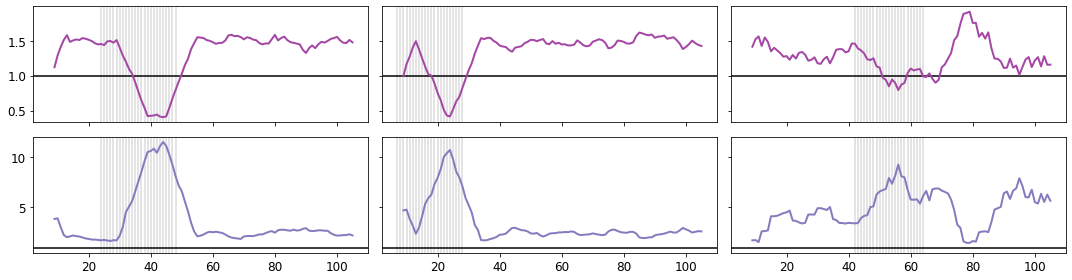

In [53]:
import itertools
import ast
import os
import duckdb

fig, ax = plt.subplots(2, 3, figsize=(15, 4), sharey='row', sharex='all')

ax = ax.ravel()

# directory where the experiment data is stored
flow_data_dir = '../../rival_framings_demand/xdd_parquet_flow'

no_to_realization = lambda x: (int((x-1)/10)+1, (x-1)%10+1)

realizations = [39, 31, 949]

colors = ['#436436','#F29A00','#774294']
labels = ['group_2','group_4', 'group_6']
for i in range(3):
    realization_index = realizations[i]
    # get sample and realization for file retrieval
    sample, real = no_to_realization(realization_index)
    # get years that are in drought in specific realization
    years = list(itertools.chain.from_iterable(ast.literal_eval(droughts_df.at[int(realization_index),'Drought years'])))
    years = tuple([x for x in years])

    # only do the following if there's at least one drought year
    # if there is no drought, values will stay default (zero) and we only need to calculate outflow percentile

    # target glob path
    glob_path = os.path.join(flow_data_dir, f'S{sample}_{real}.parquet')

    sql = f"""
    SELECT
        SUM(river_outflow)*1233.4818/1000000 AS annual_river_outflow
    FROM
        '{glob_path}'
    GROUP BY
        structure_id
        ,year
    HAVING
        structure_id = '09163500'
    ORDER BY
        year;
    """     
    df_flows = duckdb.query(sql).df()

    sql = f"""
    SELECT 
        year
        ,SUM(shortage) AS aggregate_shortage
        ,SUM(demand) AS aggregate_demand
    FROM
        '{glob_path}'
    WHERE
        structure_id NOT LIKE '09%'
    GROUP BY
        year
    ORDER BY
        year; 
    """
    df_ratio = duckdb.query(sql).df()

    df_ratio['ratio'] = df_ratio['aggregate_shortage']/df_ratio['aggregate_demand']
    df_ratio['ratio'] = df_ratio['ratio'].fillna(0)

    #calculate percentage change from history

    flow_change = df_flows['annual_river_outflow'].rolling(10).sum()/historic_deliveries
    # ratio_change = (df_ratio['ratio']-historic_mean_shortage)*100
    # user_change = (np.asarray(user_percentage) - historic_users)*100

    cumulative_deficit = df_ratio['aggregate_shortage'].rolling(10).sum()/historic_mean_cum_shortage

    ax[i].plot(np.arange(106), flow_change, 
             color= '#A447A5', linewidth=2, label='flows', zorder=10)
    # ax[0].plot(np.arange(1908,2014), ratio_change, 
    #          color= 'purple', linewidth=2, label='ratio', zorder=10)
    ax[i+3].plot(np.arange(106), cumulative_deficit, 
             color= '#857BBE', linewidth=2, label='users', zorder=10)
    
    ax[i].axhline(y=1, color='black')
    ax[i+3].axhline(y=1, color='black')
    
    ax[i].tick_params(axis='both', labelsize='large')
    ax[i+3].tick_params(axis='both', labelsize='large')
        
#     if i!=2:
#         ax[i*2+1].set_xticklabels([])

    for year in years:
        ax[i].axvline(x = year, color = 'gainsboro', zorder=0)
        ax[i+3].axvline(x = year, color = 'gainsboro', zorder=0)
    print(np.max(cumulative_deficit))

plt.tight_layout()
plt.savefig('storylines_history.svg')
